# MDS Assignment - 1

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import PIL

## Image Compressor

In [2]:
class ImageCompressor:
    def __init__(self,img_src) -> None:
        if type(img_src) == str:
            self.image_array = cv.imread(img_src)[:,:,::-1] #cv reads images in bgr format by default
            self.img_path = img_src
        elif type(img_src) == np.ndarray:
            self.image_array = img_src
            self.img_path = f'img_{np.random.randint(0,1000000000)}.jpg'
        else:
            raise TypeError("Invalid Image Source")
        self.RCh,self.GCh,self.BCh = [self.image_array[:,:,i] for i in range(3)]
        self.compressed_image_array=None
        self.S_values = []
        self.Var_covered = []
        self.ret_dims = []
        self.num_S_values = []
        self.height,self.width = self.image_array.shape[0:2]
        self.elements_before_compression = []
        self.elements_after_compression = []

    def preprocess_single_channel(self,channel_number):
        img_channel = self.image_array[:,:,channel_number]
        mean = np.mean(img_channel,axis=0)
        std = np.std(img_channel,axis=0)
        return np.divide((np.subtract(img_channel,mean)),std),mean,std

    def compress_single_channel(self,channel_number,compression_precent):
        processed_channel,mean,std = self.preprocess_single_channel(channel_number)

        U,S,V = np.linalg.svd(processed_channel)
        ret_dims = self.get_retain_dims(S,compression_precent)
        self.ret_dims.append(ret_dims)
        self.S_values.append(S)
        self.num_S_values.append(S.shape[0])
        self.Var_covered.append(np.cumsum(np.square(S))/np.sum(np.square(S))*100)
        self.elements_before_compression.append(U.shape[0]*V.shape[1])

        U = U[:,:ret_dims]
        S = np.diag(S[:ret_dims])
        V = V[:ret_dims,:]

        self.elements_after_compression.append((U.shape[0]+V.shape[1]+1)*ret_dims)

        compressed_channel = (np.dot(np.dot(U,S),V)*std+mean)
        compressed_channel[np.where(compressed_channel>255)] = 255
        compressed_channel[np.where(compressed_channel<0)] = 0
        compressed_channel = np.uint8(compressed_channel)

        return compressed_channel

    def compress_image(self,compression_percent = 0.99,asImage=False):
        self.S_values = []
        self.num_S_values = []
        self.Var_covered = []
        self.ret_dims = []
        self.elements_before_compression = []
        self.elements_after_compression = []
        self.compression_present = compression_percent*100
        self.cRCh,self.cGCh,self.cBCh = [self.compress_single_channel(i,compression_percent) for i in range(3)]
        self.compressed_image_array = np.dstack((self.cRCh,self.cGCh,self.cBCh))
        if asImage:
            return PIL.Image.fromarray(self.compressed_image_array)
        else:
            return self.compressed_image_array
        

    def display_compressed_image(self,detailed=True,save=False):
        display_image,display_message = (self.compressed_image_array,f"Compressed Image with {self.compression_present}% details preserved") if self.compressed_image_array is not None else (self.image_array,"Image not compressed") 

        if detailed:
            fig, ax = plt.subplots(4,2,figsize=(12,7))

            ax[0,0].imshow(self.image_array)
            ax[0,0].title.set_text("Original Image")

            ax[0,1].imshow(display_image)
            ax[0,1].title.set_text(display_message)

            ax[1,0].plot(self.S_values[0],c='r')
            ax[1,0].plot([self.ret_dims[0],self.ret_dims[0]],[self.S_values[0][0],0],c='y',ls='dashed',lw=0.5)
            ax[1,0].scatter([self.ret_dims[0]],[self.S_values[0][self.ret_dims[0]]],c='y',marker='x')
            
            ax[1,1].plot(self.Var_covered[0],c='r')
            ax[1,1].plot([self.compression_present for i in range(len(self.Var_covered[0]))],c='y',ls='dashed',lw=0.5)
            ax[1,1].plot([self.ret_dims[0],self.ret_dims[0]],[self.Var_covered[0][0],100],c='y',ls='dashed',lw=0.5)
            ax[1,1].scatter([self.ret_dims[0]],[self.compression_present],c='y',marker='x')
            
            ax[2,0].plot(self.S_values[1],c='g')
            ax[2,0].plot([self.ret_dims[1],self.ret_dims[1]],[self.S_values[1][0],0],c='y',ls='dashed',lw=0.5)
            ax[2,0].scatter([self.ret_dims[1]],[self.S_values[1][self.ret_dims[1]]],c='y',marker='x')
            
            ax[2,1].plot(self.Var_covered[1],c='g')
            ax[2,1].plot([self.compression_present for i in range(len(self.Var_covered[1]))],c='y',ls='dashed',lw=0.5)
            ax[2,1].plot([self.ret_dims[1],self.ret_dims[1]],[self.Var_covered[1][0],100],c='y',ls='dashed',lw=0.5)
            ax[2,1].scatter([self.ret_dims[1]],[self.compression_present],c='y',marker='x')
            
            ax[3,0].plot(self.S_values[2],c='b')
            ax[3,0].plot([self.ret_dims[2],self.ret_dims[2]],[self.S_values[2][0],0],c='y',ls='dashed',lw=0.5)
            ax[3,0].scatter([self.ret_dims[2]],[self.S_values[2][self.ret_dims[2]]],c='y',marker='x')
            
            ax[3,1].plot(self.Var_covered[2],c='b')
            ax[3,1].plot([self.compression_present for i in range(len(self.Var_covered[2]))],c='y',ls='dashed',lw=0.5)
            ax[3,1].plot([self.ret_dims[2],self.ret_dims[2]],[self.Var_covered[2][0],100],c='y',ls='dashed',lw=0.5)
            ax[3,1].scatter([self.ret_dims[2]],[self.compression_present],c='y',marker='x')
            
            plt.setp(ax[1:,0],xlabel = "i")
            plt.setp(ax[1:,1],xlabel = "No. of singular values")
            
            ax[2,0].set_ylabel("i_th singular value")
            ax[2,1].set_ylabel("% variance covered")
            
        else:
            fig,ax = plt.subplots(1,2,figsize=(10,6))
            
            ax[0].imshow(self.image_array)
            ax[0].title.set_text("Original Image")
            
            ax[1].imshow(display_image)
            ax[1].title.set_text(display_message)
                    
        if save:
            plt.savefig(f'comparision_{self.img_path}')
        plt.show()

        
    def get_retain_dims(self,S,percent_retain):
        ret_dim = 0
        tot = np.sum(np.square(S))
        variance = np.square(S)
        variance_covered = 0
        while variance_covered < percent_retain*tot:
            variance_covered += variance[ret_dim]
            ret_dim = min(ret_dim+1,len(variance)-1)
        return ret_dim


## Video Compressor

In [3]:
class VideoCompresor:
    def __init__(self,vid_path) -> None:
        self.vid_path = vid_path
        self.video = cv.VideoCapture(self.vid_path)
        self.frame_rate=self.video.get(cv.CAP_PROP_FPS)
        self.total_frames = int(self.video.get(cv.CAP_PROP_FRAME_COUNT))
        self.frames = []
        for fno in range(0, self.total_frames):
            self.video.set(cv.CAP_PROP_POS_FRAMES, fno)
            _, image_array = self.video.read()
            self.frames.append(image_array)
        self.frames = np.array(self.frames)
        self.height,self.width = self.frames.shape[1:3]
        self.compressed_frames = []
        self.video.release()

    def compress_video(self,compression_percent=0.99):
        self.compressed_frames = []
        for frame in self.frames:
            I = ImageCompressor(frame)
            self.compressed_frames.append(I.compress_image(compression_percent))
        fourcc = cv.VideoWriter_fourcc(*'avc1')
        vid_name = self.vid_path.split('/')[-1]
        compressed_video = cv.VideoWriter(f'compressed_{vid_name}',fourcc,float(self.frame_rate),(self.width,self.height))

        for frame in self.compressed_frames:
            compressed_video.write(frame)
        compressed_video.release()


## Compressing a few images

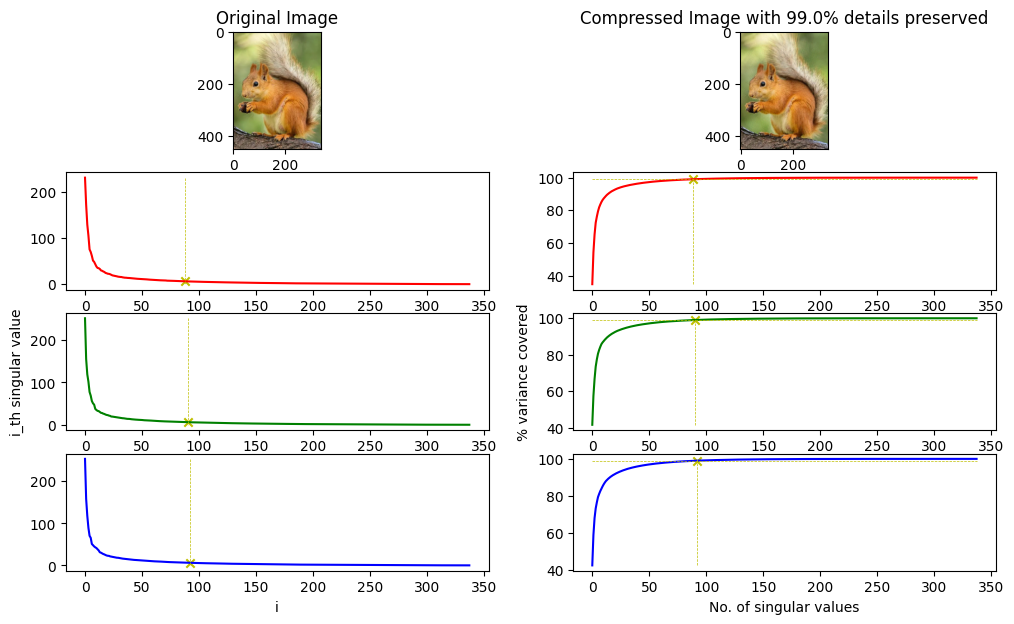

Compression Precentage 2.1419518377693283


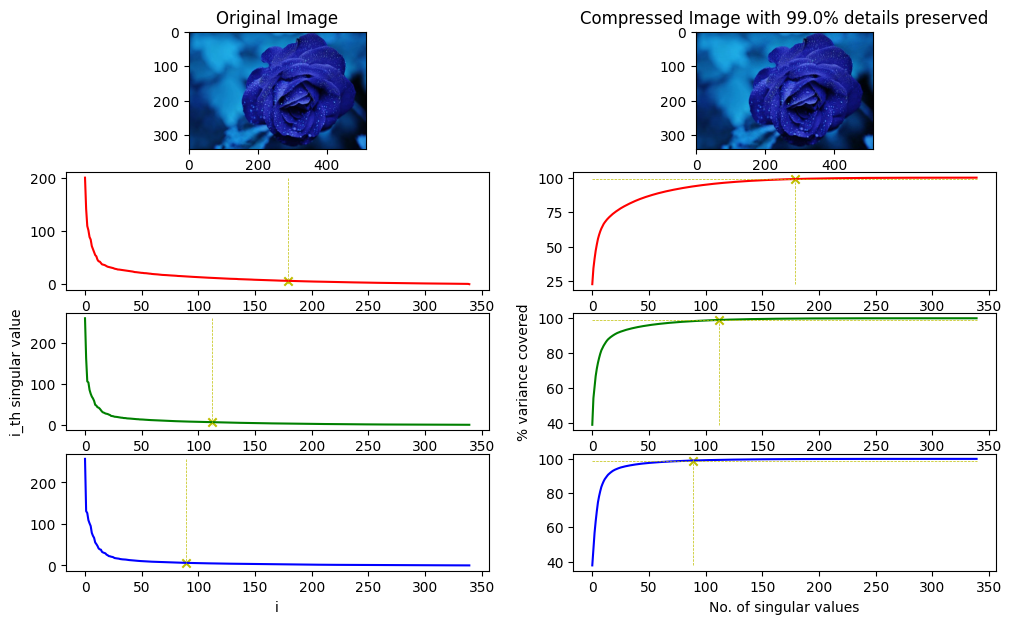

Compression Precentage 1.6124121779859484


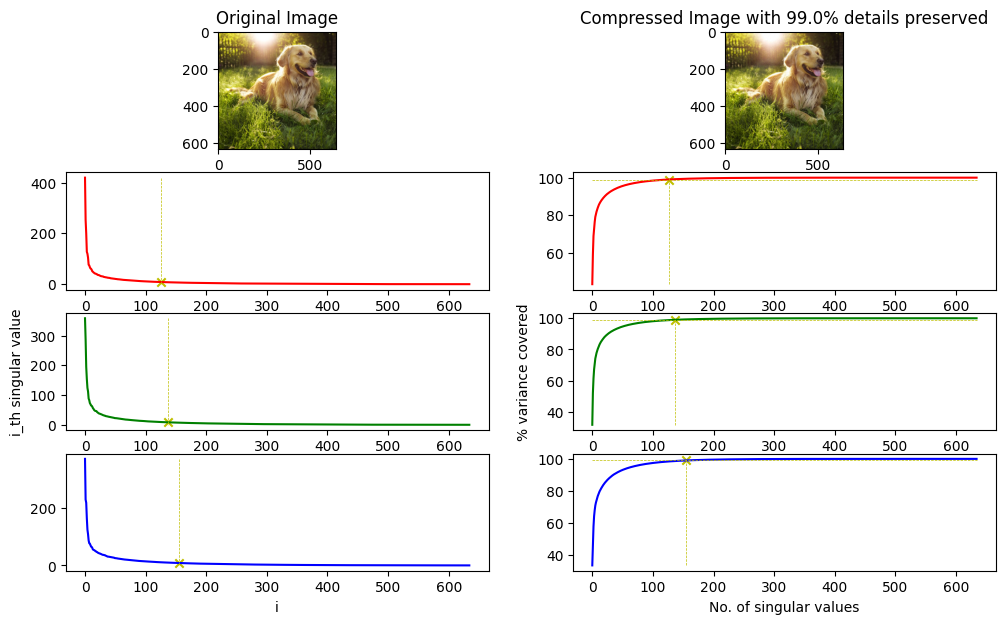

Compression Precentage 2.2858514196577224


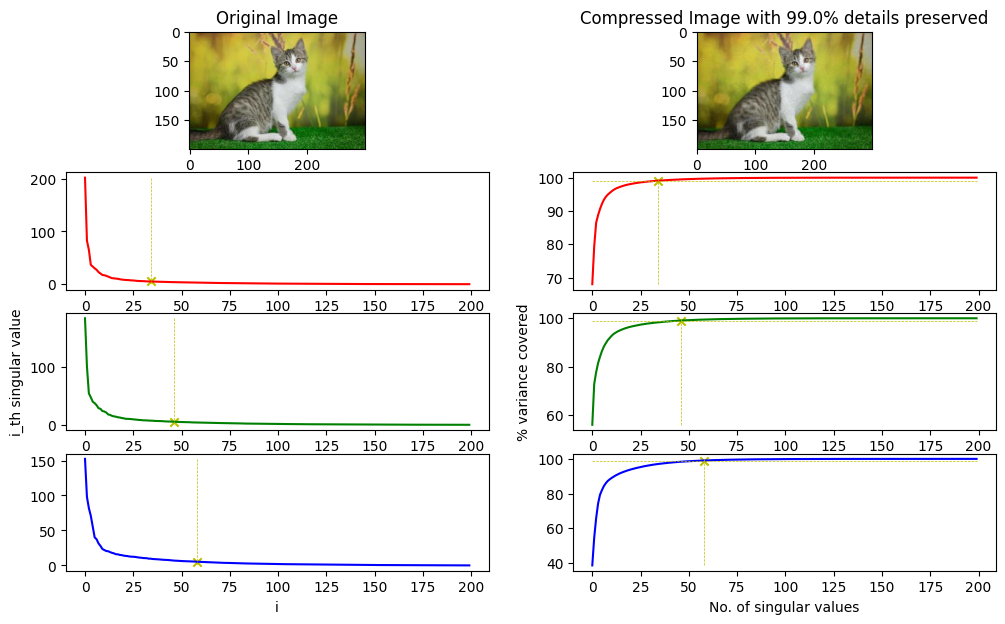

Compression Precentage 2.6034886748242645


In [4]:
for i in range(1,5):
    I = ImageCompressor(f"img-{i}.jpg")
    img = I.compress_image(0.99,True)
    img.save(f'compressed_{i}.jpg')
    I.display_compressed_image(detailed=True,save=True)#change detailed to false to view only the image_array comparision.
    print('Compression Precentage',sum(I.elements_before_compression)/sum(I.elements_after_compression))

## Compressing a few videos

In [6]:
for i in range(1,2):
    V = VideoCompresor(f"vid-{i}.mp4")
    V.compress_video(0.99)